# Binary classification : Anorexia related

In [1]:
path_corpus = {
    "test": "./path/to/test.csv",
    "training": "./path/to/train.csv",
    "dev": "./path/to/dev.csv"
}

In [2]:
def read_corpus(path, ty="main_label"):
    data = open(path, "rb").read().decode("utf-8").strip()
    labels = []
    entities = []
    texts = []
    for instance in data.split("####END-POST####"):
        if not instance=="":
            instance = instance.replace("####POST####\n", "")
            label = int(float(instance.split("####TITLE####")[0].strip().split("\n")[0]))
            if ty == "binary":
                label = int(label < 7)
            t = instance.split("####TEXT####")[1].strip()
            text = []
            ent = []
            for x in t.split("\n"):
                if not x=="":
                    text.append(x.split("\t")[0])
                    ent.append(x.split("\t")[1])
            entities.append(ent)
            texts.append(text)
            labels.append(label)
    return {"entities": entities, "texts": texts, "labels": labels}
training = read_corpus(path_corpus["training"], "binary")
dev = read_corpus(path_corpus["dev"], "binary")
test = read_corpus(path_corpus["test"], "binary")

In [3]:
def cast_data(entities, text, dict_entities=None, word2index=None, modify=True):
    dict_entities = {} if dict_entities is None else dict_entities
    entities_c = []
    for x in entities:
        entities_c_l = []
        for y in x:
            if not y in dict_entities and modify:
                dict_entities[y] = len(dict_entities)
            if not y in dict_entities:
                dict_entities[y] = dict_entities["__UNK__"]
            entities_c_l.append(dict_entities[y])
        entities_c.append(entities_c_l)
        
    text_c = []
    for x in text:
        text_c.append([0 if not y in word2index else word2index[y] for y in x])
    return entities_c, text_c, dict_entities

In [5]:
import pickle
import numpy as np

max_seq_len = 500

e, full_vocab = pickle.load(open("resources/embedding.pkl","rb"))
e = np.vstack((np.zeros((1, e.shape[1])),
                            np.random.uniform(-0.25, 0.25, e.shape[1]), e))
full_vocab["__UNK__"] = 0
full_vocab["__PAD__"] = 1

In [6]:
train_entities, train_p, d_ent = cast_data(training["entities"], training["texts"], dict_entities={"__UNK__":0}, word2index=full_vocab)
dev_entities, dev_p, d_ent = cast_data(dev["entities"], dev["texts"], dict_entities=d_ent, word2index=full_vocab, modify=False)
test_entities, test_p, d_ent = cast_data(test["entities"], test["texts"], dict_entities=d_ent, word2index=full_vocab, modify=False)

In [7]:
from keras.preprocessing.sequence import pad_sequences
d_ent["__PAD__"] = len(d_ent)

# pad sequence
train_entities = pad_sequences(train_entities, maxlen=max_seq_len, padding="post", value=d_ent["__PAD__"])
dev_entities = pad_sequences(dev_entities, maxlen=max_seq_len, padding="post", value=d_ent["__PAD__"])
test_entities = pad_sequences(test_entities, maxlen=max_seq_len, padding="post", value=d_ent["__PAD__"])

train_p = pad_sequences(train_p, maxlen=max_seq_len, padding="post", value=full_vocab["__PAD__"])
dev_p = pad_sequences(dev_p, maxlen=max_seq_len, padding="post", value=full_vocab["__PAD__"])
test_p = pad_sequences(test_p, maxlen=max_seq_len, padding="post", value=full_vocab["__PAD__"])

Using TensorFlow backend.


In [28]:
np.random.seed(500)

from keras.models import Model
from keras import losses
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, Bidirectional, Input
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers import concatenate
from sklearn.metrics import f1_score
from keras.initializers import glorot_normal

X_train = [train_entities, train_p]
X_dev = [dev_entities, dev_p]
X_test = [test_entities, test_p]
y_train = training["labels"]
y_dev = dev["labels"]
y_test = test["labels"]
x_input = Input(shape=(max_seq_len,), dtype='float32', name='pattern_input')
embedding_layer = Embedding(input_dim=e.shape[0],
                            output_dim=e.shape[1],
                            weights=[e], trainable=False) 
word = embedding_layer(x_input)
ent_input = Input(shape=(max_seq_len,))
ent = Embedding(input_dim=len(d_ent), output_dim=50, trainable=True)(ent_input)

x = concatenate([word, ent])
x = Convolution1D(128, 5, padding="valid", strides=1, activation='tanh')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x) 
model = Model(inputs=[ent_input, x_input], outputs=x)
model.summary()
model.compile(loss='binary_crossentropy', optimizer="adadelta", metrics=['acc'])
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
        ReduceLROnPlateau(patience=2, min_lr=0.0001, verbose=1, factor=0.1),
    EarlyStopping(patience=4, verbose=1)]
history = model.fit(X_train, y_train, epochs=20, 
                    batch_size=16, 
                    shuffle=True, verbose=1, callbacks=callbacks, validation_data=(X_dev, y_dev))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pattern_input (InputLayer)      (None, 500)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 500, 200)     3455600     pattern_input[0][0]              
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 500, 50)      5000        input_5[0][0]               

834/834 [==============================] - 5s 5ms/step
Test Set Accuracy: 89.09%
 Macro F1-Score:  0.8261206254653761


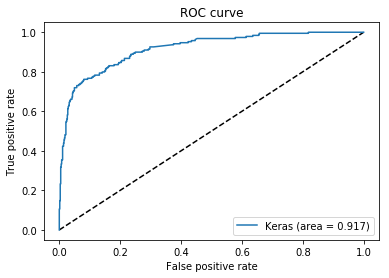

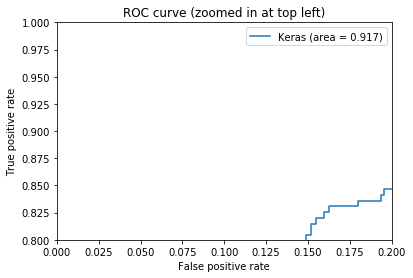

In [29]:
import matplotlib.pyplot as plt
test_loss_content, test_acc_content = model.evaluate(X_test, y_test)
print("Test Set Accuracy: %0.2f%%"%(test_acc_content*100))
y_pred_test = model.predict(X_test)
y_test_classes_pred = (y_pred_test>0.5).astype(np.int)
y_pred_train = model.predict(X_train)
y_train_classes_pred = (y_pred_train>0.5).astype(np.int)
y_pred_dev = model.predict(X_dev)
y_dev_classes_pred = (y_pred_dev>0.5).astype(np.int)
print(" Macro F1-Score: ",f1_score(y_test, y_test_classes_pred, average='macro'))
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_test)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()
plt.show()

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred_dev = model.predict(X_dev)
y_dev_classes_pred = (y_pred_dev > 0.5).astype(np.int)
print(classification_report(dev["labels"], y_dev_classes_pred))
print(confusion_matrix(dev["labels"], y_dev_classes_pred))

y_pred_test = model.predict(X_test)
y_test_classes_pred = (y_pred_test > 0.5).astype(np.int)
print(classification_report(test["labels"], y_test_classes_pred))
print(confusion_matrix(test["labels"], y_test_classes_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       765
           1       0.80      0.65      0.72       220

   micro avg       0.89      0.89      0.89       985
   macro avg       0.85      0.80      0.82       985
weighted avg       0.88      0.89      0.88       985

[[730  35]
 [ 77 143]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       645
           1       0.86      0.62      0.72       189

   micro avg       0.89      0.89      0.89       834
   macro avg       0.88      0.79      0.83       834
weighted avg       0.89      0.89      0.88       834

[[626  19]
 [ 72 117]]
